In [ ]:
"""
polarizationMulti.ipynb analyses polarization and Stokes I FITS files and returns images of a given target in polarization intensity, polarization fraction, and total intensity. 
It also averages data across all observations to get a factor of sqrt(numObservations) reduction in noise.

"""

# constants and import
# import argparse
from astropy.io import fits
from astropy.wcs import WCS
# from astropy.table import Table
# from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np
# from scipy.constants import c
# from scipy.ndimage import label

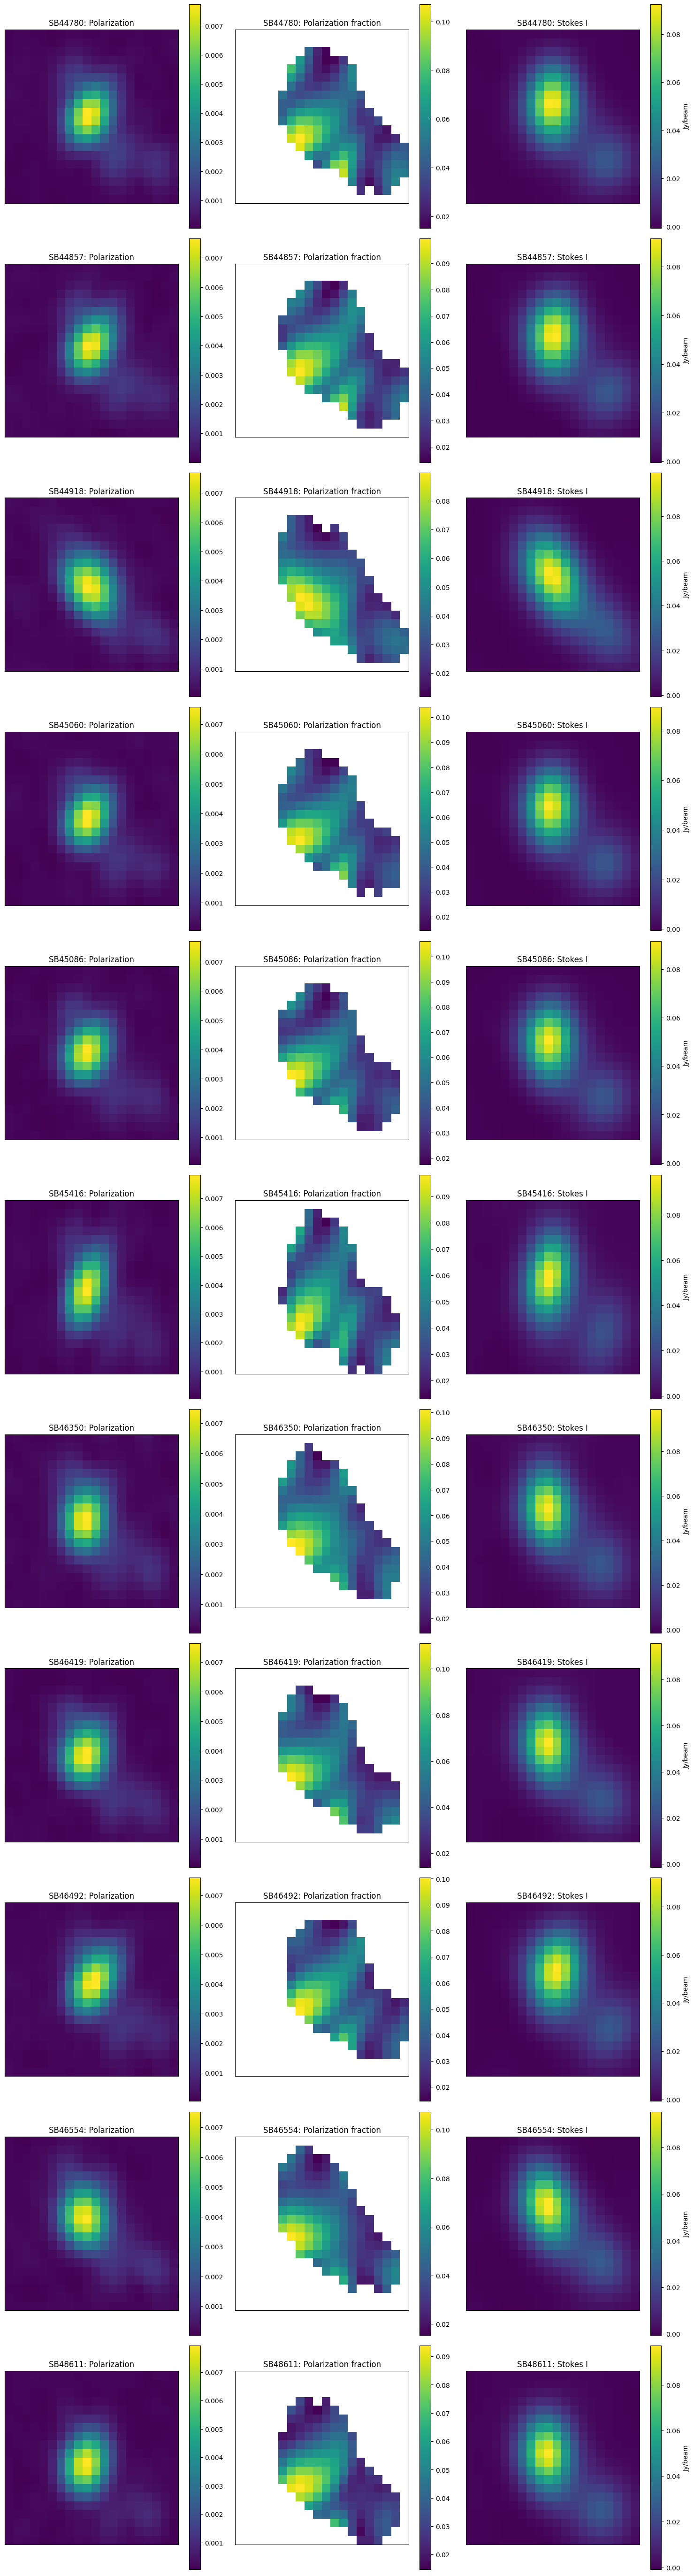

In [ ]:
# plot the region around the target (GRB221009A) in polarization, polarization fraction, and Stokes I

# GRB221009A rough pixel coordinates are (1630, 1725) (y,x)
# Catalog source 1 rough pixel coords (944, 2281)
# Catalog source 2 rough pixel coords (2611, 1705)

targetPix = (1630, 1725)
targetRegion = eval('slice(targetPix[0]-searchRadius,targetPix[0]+searchRadius), slice(targetPix[1]-searchRadius, targetPix[1]+searchRadius)')
dataPavg = np.zeros((3240,3240)) # should match the shape of the FITS files data
dataIavg = np.zeros_like(dataPavg)
searchRadius = 10 # half the side length of the square to search for 
SBIDlist = ['44780', '44857', '44918', '45060', '45086', '45416', '46350', '46419', '46492', '46554', '48611'] # specify the scheduling block IDs for each observation
numObs = len(SBIDlist)
targetPlist = np.empty(numObs)
targetPfraclist = np.empty(numObs)

fig, axes = plt.subplots(numObs, 3, figsize=(15, 5*numObs))
# fig.suptitle('Polarization (left), Polarization fraction (middle), Stokes I (right)')

for k, sbid in enumerate(SBIDlist):

    # polarization
    with fits.open(f'sb{sbid}/results/SB{sbid}-MFS-P-image.fits') as hdulObsP: 
        dataObsP = hdulObsP[0].data
    sliceP = dataObsP[targetRegion]
    targetPlist[k] = np.nanmax(sliceP)
    dataPavg += dataObsP / numObs # just averaging the slice would suffice, but having the whole image may become useful

    # polarization fraction
    with fits.open(f'sb{sbid}/results/SB{sbid}-MFS-Pfrac-image.fits') as hdulObsPf:  
        dataObsPf = hdulObsPf[0].data
    slicePf = dataObsPf[targetRegion]
    targetPfraclist[k] = np.nanmax(slicePf)
    dataIavg += dataObsI / numObs

    # Stokes I
    with fits.open(f'sb{sbid}/image/SB{sbid}-MFS-image.fits') as hdulObsI:
        dataObsI = hdulObsI[0].data[0,0]
    sliceI = dataObsI[targetRegion]
    
    # Plot P
    im0 = axes[k, 0].imshow(sliceP, origin='lower', cmap='viridis')
    axes[k, 0].set_title(f'SB{sbid}: Polarization')
    axes[k, 0].set_xticks([])  # Hide x-axis ticks
    axes[k, 0].set_yticks([])  # Hide y-axis ticks
    plt.colorbar(im0, ax=axes[k, 0])
    
    # Plot Pfrac
    im1 = axes[k, 1].imshow(slicePf, origin='lower', cmap='viridis')
    axes[k, 1].set_title(f'SB{sbid}: Polarization fraction')
    axes[k, 1].set_xticks([])  # Hide x-axis ticks
    axes[k, 1].set_yticks([])  # Hide y-axis ticks
    plt.colorbar(im1, ax=axes[k, 1])

    # Plot Stokes I
    im2 = axes[k, 2].imshow(sliceI, origin='lower', cmap='viridis')
    axes[k, 2].set_title(f'SB{sbid}: Stokes I')
    axes[k, 2].set_xticks([])  # Hide x-axis ticks
    axes[k, 2].set_yticks([])  # Hide y-axis ticks
    plt.colorbar(im2, ax=axes[k, 2], label='Jy/beam')

plt.tight_layout()
plt.show()

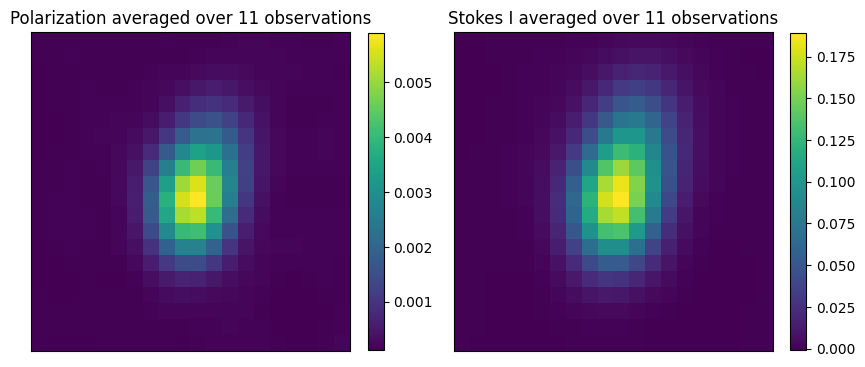

In [50]:
# plot the region around the target (GRB221009A) in polarization, polarization fraction, and Stokes I
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
PAvgImage = axes[0].imshow(dataPavg[targetRegion], origin='lower', cmap='viridis')
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
axes[0].set_title(f'Polarization averaged over {numObs} observations')
plt.colorbar(PAvgImage, ax=axes[0], fraction=.045)
IAvgImage = axes[1].imshow(dataIavg[targetRegion], origin='lower', cmap='viridis')
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
axes[1].set_title(f'Stokes I averaged over {numObs} observations')
plt.colorbar(IAvgImage, ax=axes[1], fraction=.045);
